<a href="https://colab.research.google.com/github/panos108/barrier/blob/master/GP_DynamicSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pylab
import numpy as np
import scipy.integrate as scp
from pylab import *
import matplotlib.pyplot as plt
#secondary utilities
import csv
#import itertools
import os
import sys
import copy
import numpy.random as rnd
from scipy.spatial.distance import cdist
!pip install sobol_seq
import sobol_seq
from scipy.optimize import minimize


  Created wheel for sobol-seq: filename=sobol_seq-0.1.2-cp36-none-any.whl size=8189 sha256=690389b8cf8996c39bc3658ffe5f31b4080558ac8557eb346cbd6d4d0ce13fda
  Stored in directory: /root/.cache/pip/wheels/d5/72/1f/6cd8a0b472da802ee9c84fdc39626bb4ec544668c030917d9f
Successfully built sobol-seq


# Modelling dynamical systems with Gaussian processes

We consider the nonlinear discrete-time system:

$$x_{k+1}=f(x_k,u_k)$$

with states $x \in \mathbb{X} \subseteq \mathbb{R}^n$, inputs (controls) $u \in \mathbb{U} \subseteq \mathbb{R}^r$, and $k$ marking the time-step where $k \in \mathbb{N}^0$ (meaning that $k$ can take positive integer real numbers including zero).

We assume that we can fully measure the current state, and that the consecutive state can also be measured but with noise. 

Hece we have a dataset of states and control measurements $\{ x^{(i)},u^{(i)} \}$ with its corresponding consecutive state noisy measurement $ y^{(i)}=f(x^{(i)}_k,u^{(i)}_k) + \epsilon $, where $\epsilon \sim \mathcal{N}(0,\sigma^2_n {\bf I}_n)$

We can then state our dataset as:
$$\mathcal{D}=\{ \{ x_k^{(i)},u_k^{(i)} \}, y^{(i)} \}_{i=1}^N$$

For ease on notation, we group the input variables as $\xi^{(i)}_k= [ x_k^{(i)},u_k^{(i)} ]$ and that $\xi \in \mathcal{X} \subseteq \mathbb{R}^p $, where $n+r=p$.



## State-state model with Gaussian processes

To model dynamical systems with GPs, we will use state-space models. That is, we will use a GP as a state-space model of the dynamical system. For this, we use $N$ samples (our dataset) to construct our GP state-space model.

We interprete the Gaussian process as a *distribution over functions* as follows:

$$f_{\psi}(\xi) \sim \mathcal{GP}(m_{\psi}(\xi),k_{\psi}(\xi,\xi'))$$

which is fully characterized by a mean $m_{\psi}(\xi):\mathcal{X} \rightarrow \mathbb{R}$ and a covariance function $k_{\psi}(\xi,\xi'):\mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$. Notice that both the mean and covariance produce a scalar. This means that they map control and state inputs $\xi$ to a single output. This means that if we want to produce $n$ outputs (say, one for each state at a subsequent time), we must have $n$ GPs, one for each state. 

In simple terms, this means that we will use dataset $\mathcal{D}$ to train a GP, which  given an input $\xi_k=[x_k,u_k ]$, the will predict future state $x_{k+1}$ (with a mean value, and a variance). Later we will see this can have multiple interpretations, but for now this is accurate and concise enough.

Therefore, to model functions with multidimensional outputs, such as dynamics, $n$ independent GPs are concatenated:
$$f_{\Psi}(\xi)=
\begin{cases}
    f_{\psi_1}(\xi) \sim \mathcal{GP}(0,k_{\psi_1}(\xi,\xi')) \\
   \vdots \\
    f_{\psi_n}(\xi) \sim \mathcal{GP}(0,k_{\psi_n}(\xi,\xi'))
\end{cases}$$

We can then concatenate all parameter vectors $\Psi=[\psi_1,..., \psi_n ]$ and all covariance functions $k_{\Psi}(\cdot,\cdot)=[ k_{\psi_1}(\cdot,\cdot),...,k_{\psi_n}(\cdot,\cdot) ]$ to describe the concatenation of all kernel functions into:

$$ f_{\Psi}(\xi) \sim \mathcal{GP}(0,k_{\Psi}(\xi,\xi'))$$

Notice: 
*  we always normalize our data, therefore we can have a mean of zero without losing information.
*  we always normalize our data, therefore we have a mean of zero.

## Dynamical System

In [0]:
class ModelIntegration:
    
    # --- initializing model --- #
    def __init__(self, parameters, controls, tf, x0):
        
        # Object variable definitions
        self.parameters, self.controls = parameters, controls
        self.x0, self.dt, self.tf      = x0, tf/(controls.shape[1]), tf
        self.u0                        = controls[:,0]
        
    # --- dynamic model definition --- #    
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        ctrl   = self.u0
        
        L_I    = ctrl[0]
        FCn    = ctrl[1]
        
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        Cqc = state[2]
        
        # parameters
        u_m  = params['u_m']; k_s  = params['k_s'];
        k_i  = params['k_i']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        k_m  = params['k_m']; k_sq = params['k_sq'];
        k_iq = params['k_iq']; k_d = params['k_d'];
        K_Np = params['K_Np'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * L_I/(L_I+k_s+L_I**2/k_i) * Cx * Cn/(Cn+K_N) - u_d*Cx
        dev_Cn  = - Y_nx * u_m * L_I/(L_I+k_s+L_I**2/k_i) * Cx * Cn/(Cn+K_N) + FCn
        dev_Cqc =  k_m * L_I/(L_I+k_sq+L_I**2/k_iq) * Cx - k_d*Cqc/(Cn+K_Np)
        
        return np.array([dev_Cx, dev_Cn, dev_Cqc],dtype='float64')
    
    # --- simulation --- #
    def simulation(self):
        # internal definitions
        dt, steps, x0   = self.dt, int(self.tf/float(self.dt)), self.x0
        model, controls = self.model, self.controls
        
        # compile state trajectories
        xt = np.zeros((x0.shape[0],steps+1))
        tt = np.zeros((steps+1))
        
        # initialize simulation
        current_state = x0
        xt[:,0]       = current_state
        tt[0]         = 0.
        
        # simulation
        for s in range(steps):
            self.u0   = controls[:,s]                   # control for this step
            ode       = scp.ode(model)                  # define ode
            ode.set_integrator('lsoda', nsteps=3000)    # define integrator
            ode.set_initial_value(current_state,dt)     # set initial value
            current_state = list(ode.integrate(ode.t + dt)) # integrate system
            xt[:,s+1]     = current_state                   # add current state
            tt[s+1]       = (s+1)*dt
        
        return xt, tt    
        
        
        

### Dynamical system example

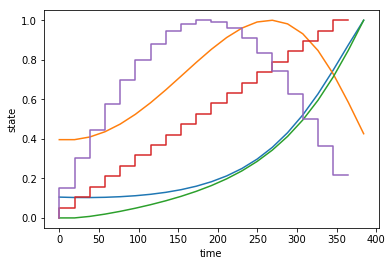

In [0]:
p  = {'u_m' : 0.0923*0.62, 'k_s' : 178.85, 'k_i' : 447.12, 'K_N' : 393.10,
     'u_d' : 0.001, 'Y_nx' : 504.49, 'k_m' : 2.544*0.62,  'k_sq' : 23.51,
     'k_iq' : 800.0, 'k_d' : 0.281, 'K_Np' : 16.89}

steps_   = 20
L_I_0    = [i*10 for i in range(steps_)]
FCn_0    = [np.sin(i/6.5)*2. for i in range(steps_)]

u  = np.array([L_I_0, FCn_0])
tf = 16.*24.
x0 = np.array([0.1,150.0,0.0])


m      = ModelIntegration(p, u, tf, x0)
xt, tt = m.simulation() 

# --- plot results --- #

import matplotlib.pyplot as plt
for i in range(xt.shape[0]):
    plt.plot(tt,xt[i,:]/np.max(xt[i,:]))
plt.step(tt[:-1],L_I_0/np.max(L_I_0))
plt.step(tt[:-1],FCn_0/np.max(FCn_0))
plt.ylabel('state')
plt.xlabel('time')
plt.show()



### Creating Training datasets

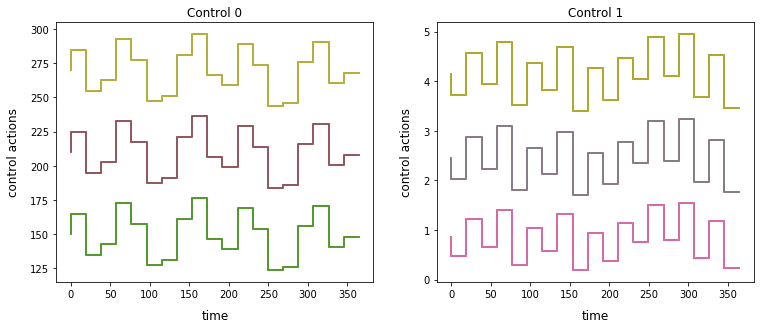

In [0]:
# We create a range of control sequences to have different dynamic trajectories

# ranges for design of experiments
LI_ranges    = np.array([[120.,180.],[180.,240.],[240.,300.]])
FCn_ranges   = np.array([[0.1,1.6],[1.6,3.3],[3.3,5.]])
cntrl_bounds = np.zeros((2,2,3,3))
dt           = tf/float(steps_)
tt_          = [dt*i for i in range(steps_)]

# total number of experiments
experiments = 9
# create matrix of combinatorial bounds
for bi in range(3):
    for bj in range(3):
        cntrl_bounds[:,:,bi,bj] = np.vstack((LI_ranges[bi,:],FCn_ranges[bj,:]))

# create sobol sequnce
ctrl_sobol    = sobol_seq.i4_sobol_generate(2,steps_) # shape (steps_, 2)
cntrl_actions = np.zeros((9,2,steps_))

# computing control sequences
seqi = 0
for bi in range(3):
    for bj in range(3):
        # computing upper and lower bounds
        lb                      = cntrl_bounds[:,0,bi,bj]
        ub                      = cntrl_bounds[:,1,bi,bj]  
        # computing control sequences        
        cntrl_actions[seqi,:,:] = (lb + (ub-lb)*ctrl_sobol[:,:]).T
        seqi                   += 1

# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(12.5, 10.5)

for ci in range(0,2):
        
    # --- plot loop --- #   
    # setting up plot
    ax = fig.add_subplot(2, 2, ci+1)

    # labels and titles
    ax.set_title('Control '+str(ci), fontsize=12)
    ax.set_xlabel('time', fontsize=12, labelpad=10)
    ax.set_ylabel('control actions', fontsize=12, labelpad=10)

    # states
    for i in range(0,experiments):
        ax.step(tt_,cntrl_actions[i,ci,:])
        
plt.show()

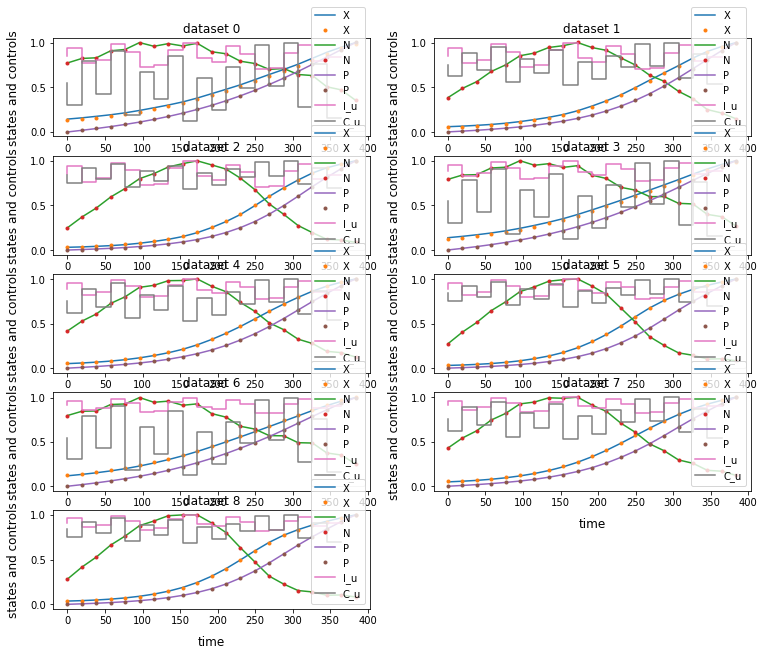

In [0]:
######################################
# --- Creating Training datasets --- #
######################################

# L_I range [120, 300]
# FCn range [0.1, 5.0]

# --- problem parameters --- #
experiments = 9
steps_      = 20
tf          = 16.*24.
nd          = 3 
nu          = 2
x0          = np.array([0.1,150.0,0.0])
Sigma_v     = np.array([0.8,250.0,80.0])*diag(np.ones(nd))*1e-4


# --- input arrays --- #
L_I_0 = cntrl_actions[:,0,:]
FCn_0 = cntrl_actions[:,1,:]
LI_np  = np.array(L_I_0)
FCn_np = np.array(FCn_0)

# --- data collectors --- #
Xdat = np.zeros((experiments*steps_, nd+nu ))
Ydat = np.zeros((experiments*steps_, nd))

# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(12.5, 10.5)

for ri in range(0,experiments):
    u       = np.array([L_I_0[ri], FCn_0[ri]])
    m       = ModelIntegration(p, u, tf, x0)
    xt, tt  = m.simulation()
    # -- adding noise -- #
    xt_real = xt
    xt      = xt + np.random.multivariate_normal(np.zeros(nd),
                                                 Sigma_v).reshape(nd,1) 
    
    # -- gathering data states -- #
    t_                          = ri*steps_
    Xdat[t_:t_+steps_,:nd]      = xt_real[:,:-1].T # no noise on input
    Ydat[t_:t_+steps_,:]        = xt[:,1:].T       # noise on output
    # -- gathering data controls -- #
    Xdat[t_:t_+steps_, nd  :nd+1] = LI_np[ri,:].reshape(steps_,1)
    Xdat[t_:t_+steps_, nd+1:nd+2] = FCn_np[ri,:].reshape(steps_,1)
    
    # --- plot loop --- #   
    # setting up plot
    ax = fig.add_subplot(int(experiments/2.)+1, 2, ri+1)

    # labels and titles
    ax.set_title('dataset '+str(ri), fontsize=12)
    ax.set_xlabel('time', fontsize=12, labelpad=10)
    ax.set_ylabel('states and controls', fontsize=12, labelpad=10)

    # states
    for i in range(xt.shape[0]):
        ax.plot(tt,xt[i,:]/np.max(xt[i,:]))
        ax.plot(tt,xt_real[i,:]/np.max(xt[i,:]),'.')
    # controls
    ax.step(tt[:-1],L_I_0[ri]/np.max(L_I_0[ri]))
    ax.step(tt[:-1],FCn_0[ri]/np.max(FCn_0[ri]))

    ax.legend(('X','X', 'N', 'N', 'P', 'P', 'l_u', 'C_u'),
               loc='lower right')
plt.show()

## Gaussian process

In [0]:
class GP_model:
    
    ###########################
    # --- initializing GP --- #
    ###########################    
    def __init__(self, X, Y, kernel, multi_hyper):
        
        # GP variable definitions
        self.X, self.Y, self.kernel = X, Y, kernel
        self.n_point, self.nx_dim   = X.shape[0], X.shape[1]
        self.ny_dim                 = Y.shape[1]
        self.multi_hyper            = multi_hyper
        
        # normalize data
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std
        
        # determine hyperparameters
        self.hypopt, self.invKopt   = self.determine_hyperparameters()        
    
    #############################
    # --- Covariance Matrix --- #
    #############################    
    
    def Cov_mat(self, kernel, X_norm, W, sf2):
        '''
        Calculates the covariance matrix of a dataset Xnorm
        --- decription ---
        '''
    
        if kernel == 'RBF':
            dist       = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*dist)
            return cov_matrix
            # Note: cdist =>  sqrt(sum(u_i-v_i)^2/V[x_i])
        else:
            print('ERROR no kernel with name ', kernel)

    ################################
    # --- Covariance of sample --- #
    ################################    
        
    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        '''
        Calculates the covariance of a single sample xnorm against the dataset Xnorm
        --- decription ---
        '''    
        # internal parameters
        nx_dim = self.nx_dim

        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)

        return cov_matrix                
        
    ###################################
    # --- negative log likelihood --- #
    ###################################   
    
    def negative_loglikelihood(self, hyper, X, Y):
        '''
        --- decription ---
        ''' 
        # internal parameters
        n_point, nx_dim = self.n_point, self.nx_dim
        kernel          = self.kernel
        
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        K       = self.Cov_mat(kernel, X, W, sf2)  # (nxn) covariance matrix (noise free)
        K       = K + (sn2 + 1e-8)*np.eye(n_point) # (nxn) covariance matrix
        K       = (K + K.T)*0.5                    # ensure K is simetric
        L       = np.linalg.cholesky(K)            # do a cholesky decomposition
        logdetK = 2 * np.sum(np.log(np.diag(L)))   # calculate the log of the determinant of K the 2* is due to the fact that L^2 = K
        invLY   = np.linalg.solve(L,Y)             # obtain L^{-1}*Y
        alpha   = np.linalg.solve(L.T,invLY)       # obtain (L.T L)^{-1}*Y = K^{-1}*Y
        NLL     = np.dot(Y.T,alpha) + logdetK      # construct the NLL

        return NLL
    
    ############################################################
    # --- Minimizing the NLL (hyperparameter optimization) --- #
    ############################################################   
    
    def determine_hyperparameters(self):
        '''
        --- decription ---
        Notice we construct one GP for each output
        '''   
        # internal parameters
        X_norm, Y_norm  = self.X_norm, self.Y_norm
        nx_dim, n_point = self.nx_dim, self.n_point
        kernel, ny_dim  = self.kernel, self.ny_dim
        Cov_mat         = self.Cov_mat
        
        
        lb               = np.array([-4.]*(nx_dim+1) + [-8.])  # lb on parameters (this is inside the exponential)
        ub               = np.array([4.]*(nx_dim+1) + [ -2.])   # lb on parameters (this is inside the exponential)
        bounds           = np.hstack((lb.reshape(nx_dim+2,1),
                                      ub.reshape(nx_dim+2,1)))
        multi_start      = self.multi_hyper                   # multistart on hyperparameter optimization
        multi_startvec   = sobol_seq.i4_sobol_generate(nx_dim + 2,multi_start)

        options  = {'disp':False,'maxiter':10000}          # solver options
        hypopt   = np.zeros((nx_dim+2, ny_dim))            # hyperparams w's + sf2+ sn2 (one for each GP i.e. output var)
        localsol = [0.]*multi_start                        # values for multistart
        localval = np.zeros((multi_start))                 # variables for multistart

        invKopt = []
        # --- loop over outputs (GPs) --- #
        for i in range(ny_dim):    
            # --- multistart loop --- # 
            for j in range(multi_start):
                print('multi_start hyper parameter optimization iteration = ',j,'  input = ',i)
                hyp_init    = lb + (ub-lb)*multi_startvec[j,:]
                # --- hyper-parameter optimization --- #
                res = minimize(self.negative_loglikelihood,hyp_init,args=(X_norm,Y_norm[:,i])\
                               ,method='SLSQP',options=options,bounds=bounds,tol=1e-12)
                localsol[j] = res.x
                localval[j] = res.fun

            # --- choosing best solution --- #
            minindex    = np.argmin(localval)
            hypopt[:,i] = localsol[minindex]
            ellopt      = np.exp(2.*hypopt[:nx_dim,i])
            sf2opt      = np.exp(2.*hypopt[nx_dim,i])
            sn2opt      = np.exp(2.*hypopt[nx_dim+1,i]) + 1e-8

            # --- constructing optimal K --- #
            Kopt        = Cov_mat(kernel, X_norm, ellopt, sf2opt) + sn2opt*np.eye(n_point)
            # --- inverting K --- #
            invKopt     += [np.linalg.solve(Kopt,np.eye(n_point))]

        return hypopt, invKopt

    ########################
    # --- GP inference --- #
    ########################     
    
    def GP_inference_np(self, x, var_out=True):
        '''
        --- decription ---
        '''
        nx_dim                   = self.nx_dim
        kernel, ny_dim           = self.kernel, self.ny_dim
        hypopt, Cov_mat          = self.hypopt, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.invKopt
        Xsample, Ysample         = self.X_norm, self.Y_norm
        # Sigma_w                = self.Sigma_w (if input noise)

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        # --- Loop over each output (GP) --- #
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # --- determine covariance of each output --- #
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = sf2opt - np.matmul(np.matmul(k.T,invK),k)
            #var[i] = sf2opt + Sigma_w[i,i]/stdY[i]**2 - np.matmul(np.matmul(k.T,invK),k) (if input noise)

        # --- compute un-normalized mean --- #    
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        if var_out:
            return mean_sample, var_sample
        else:
            return mean_sample

           

### Fit GP with dynamica data

In [0]:
# --- build a GP model --- #
GP_m = GP_model(Xdat, Ydat, 'RBF', multi_hyper=10)

multi_start hyper parameter optimization iteration =  0   input =  0
multi_start hyper parameter optimization iteration =  1   input =  0
multi_start hyper parameter optimization iteration =  2   input =  0
multi_start hyper parameter optimization iteration =  3   input =  0
multi_start hyper parameter optimization iteration =  4   input =  0
multi_start hyper parameter optimization iteration =  5   input =  0
multi_start hyper parameter optimization iteration =  6   input =  0
multi_start hyper parameter optimization iteration =  7   input =  0
multi_start hyper parameter optimization iteration =  8   input =  0
multi_start hyper parameter optimization iteration =  9   input =  0
multi_start hyper parameter optimization iteration =  0   input =  1
multi_start hyper parameter optimization iteration =  1   input =  1
multi_start hyper parameter optimization iteration =  2   input =  1
multi_start hyper parameter optimization iteration =  3   input =  1
multi_start hyper parameter optimi

### Simulating the GP

This function simulates a trained GP state space model for for several time-steps

In [0]:
#######################################################
# --- Simulating GP (No uncertainty propagation)  --- #
#######################################################

class GP_simulate:
    
    ###########################
    # --- initializing GP --- #
    ###########################    
    def __init__(self, GP, x0, controls):
        
        # variable inputs
        self.GP, self.x0 = GP, x0
        self.controls    = controls            # shape (nu, steps)
        self.steps       = controls.shape[1]
     
        # internal variable definition
        self.udim, self.ydim = controls.shape[0],  x0.shape[0]
        self.xdim            = controls.shape[0] + x0.shape[0]
        
    #####################################
    # --- one-step ahead prediction --- #
    #####################################   
    
    def one_step(self, Xt):
        '''
        --- decription ---
        ''' 
        # internal variable definition
        GP = self.GP
        
        yt_mean, yt_std   = GP.GP_inference_np(Xt)

        return yt_mean, yt_std
    
    ####################################################################
    # --- multi-step ahead prediction (No uncertainty propagation) --- #
    ####################################################################   
    
    def multi_step_noprop(self):
        '''
        --- decription ---
        ''' 
        # internal variable definition
        one_step, controls = self.one_step, self.controls
        steps, x0, ydim    = self.steps, self.x0, self.ydim
        
        # creating lists to store data (includes initial control, hence +1)
        Y_mean = np.zeros((steps+1,ydim))
        Y_std  = np.zeros((steps+1,ydim))
        
        # starting process
        xnew        = x0
        Y_mean[0,:] = xnew
        Y_std[0,:]  = np.zeros((xnew.shape))
        
        # GP simulation
        for si in range(steps):
            x             = np.hstack((xnew,controls[:,si]))
            ymean, ysigma = one_step(x)
            xnew          = ymean
            
            
            Y_mean[si+1,:] = ymean
            Y_std[si+1,:]  = ysigma

        return Y_mean, Y_std
    
    ######################################################################
    # --- multi-step ahead prediction (WITH uncertainty propagation) --- #
    ######################################################################   
    
    def multi_step_withprop(self):
        '''
        --- decription ---
        ''' 
        # internal variable definition
        one_step, controls    = self.one_step, self.controls
        steps, x0, ydim, xdim = self.steps, self.x0, self.ydim, self.xdim
        step_Uncert_prop      = self.step_Uncert_prop
        n_controls, X_mean    = controls.shape[0], self.GP.X_mean
        
        # creating lists to store data (includes initial control, hence +1)
        Y_mean = np.zeros((steps+1,ydim))
        Y_std  = np.zeros((steps+1,ydim))
        
        # starting process
        xnew        = x0
        Y_mean[0,:] = xnew
        Y_std[0,:]  = np.zeros((xnew.shape))
        
        # GP simulation
        for si in range(steps):
            print('============== step ============',si)
                        
            if si == 0:
                x            = np.hstack((xnew,controls[:,si])) # add control
                ynew, ysigma = one_step(x)                      # compute next step
                ycov         = np.identity(ydim)*ysigma         # make matrix (ydim x ydim)
                xcov         = np.hstack(( ycov, 
                                          np.zeros((ydim, n_controls)) )) # make matrix (ydim x xdim)
            else:
                xnew       = ynew
                x          = np.concatenate((xnew,controls[:,si])) # add control
                #print('xcov = ',xcov)
                #print('xcov.shape = ',xcov.shape)
                #print('np.zeros((n_controls,xdim)) = ',np.zeros((n_controls,xdim)))
                #print('np.zeros((n_controls,xdim)).shape = ',np.zeros((n_controls,xdim)).shape)
                
                xcov       = np.vstack((xcov, np.zeros((n_controls,xdim)))) # add control uncertaint make matrix (xdim x xdim)
                #print('xcov = ',xcov)
                #print('xcov.shape = ',xcov.shape)
                
                xcov       = xcov# + np.identity((xcov.shape[0]))*X_mean*1e-3 # add positive definite term
                ynew, ycov = step_Uncert_prop(x, xcov)      # step with uncertainty propagation    
                print('ycov = ',ycov)
                print('ynew = ',ynew)

                ysigma     = np.diag(ycov)                  # get diagonal elements for plotting
                xcov       = np.hstack(( ycov,
                                        np.zeros((ydim, n_controls)) )) # make matrix (ydim x xdim)
                        
            Y_mean[si+1,:] = ynew
            Y_std[si+1,:]  = ysigma

        return Y_mean, Y_std
    
    ###################################
    # --- Uncertainty propagation --- #
    ###################################

    def step_Uncert_prop(self, m, s):
        '''
        --- decription ---
        m = mean of input distribution
        s = standard deviation of input distribution
        '''
        print('Uncertainty propagation only available for Gaussian kernel')
        # internal variable definition
        GP, xdim, ydim             = self.GP, self.xdim, self.ydim
        hypopt, invKopt, n_point   = GP.hypopt, GP.invKopt, GP.n_point
        stdX, stdY, meanX, meanY   = GP.X_std, GP.Y_std, GP.X_mean, GP.Y_mean
        X_norm_train, Y_norm_train = GP.X_norm, GP.Y_norm
        
        #X = self.X
        
        # variable definition
        m    = (m - meanX) / stdX               # normalize mean
        s    = s / stdX ** 2                    # normalize std
        mean = np.zeros(ydim)
        var  = np.zeros([ydim, ydim])
        beta = np.zeros([n_point, ydim])
        k    = np.zeros([n_point, ydim])
        z_a  = np.zeros([xdim, n_point, n_point])
        kk   = np.zeros([n_point, n_point])
        Q    = np.zeros([n_point, n_point])

        # samples - mean value
        nu = X_norm_train - m.T

        # --- Loop over each output (GP) --- #
        for a in range(ydim):
            # --- parameters of each output --- #
            invK           = invKopt[a]
            hyper          = hypopt[:, a]
            ellopt, sf2opt = np.exp(2 * hyper[:xdim]), np.exp(2 * hyper[xdim])
            Lambda         = np.diag(ellopt) # diagonalize the vector
            
            # --- determine covariance of each output --- #
            # Begin computation of mean (same as original GP)
            beta[:, a] = invK @  Y_norm_train[:, a]
            #print('s = ',s)
            #print('pinv(Lambda) = ',pinv(Lambda))
            #print('s @ pinv(Lambda) = ',s @ pinv(Lambda))
            #print('s  = ',s )
            #print('pinv(Lambda) = ',pinv(Lambda))
            aa         = sf2opt / (np.sqrt(np.linalg.det(s @ pinv(Lambda)+np.eye(xdim))))
            q          = aa * (np.diag(np.exp(-0.5 * nu @ pinv(s + Lambda) @ nu.T)))
            # output mean value 
            mean[a]    = beta[:, a].T@q # k.T*Kinv*y

            # --- begin computation of covariance --- #
            k[:, a] = np.diag(sf2opt * np.exp(-0.5 * nu @ pinv(Lambda) @ nu.T))
            z_a1    = pinv(Lambda) @ nu.T
            for b in range(a+1):
                hyperb           = hypopt[:, a] # repeated
                elloptb, sf2optb = np.exp(2 * hyperb[:xdim]), np.exp(2 * hyperb[xdim])
                Lambdab          = np.diag(elloptb)
                R                = s @ (pinv(Lambda)+pinv(Lambdab)) + np.eye(xdim)
                z_a2             = pinv(Lambdab) @ nu.T
                kk               = k[:, a].reshape([1,n_point]).T @ k[:, b].reshape([1,n_point])
                
                #qq               = np.linalg.cholesky(pinv(R) @ s)
                L_eig            = np.diagflat(np.linalg.eig(pinv(R) @ s)[0])
                X_eig            = np.linalg.eig(pinv(R) @ s)[1]
                qq               = X_eig @ np.sqrt(L_eig)            
                
                Q                = ( kk / np.sqrt(np.linalg.det(R)) * 
                                    np.exp(0.5 * cdist(z_a1.T @ qq, -z_a2.T @ qq, 
                                                       'euclidean', V=np.ones(xdim))**2) )
                var[a, b]        = beta[:, a].T @ Q @ beta[:, b] - mean[a]*mean[b]
                var[a, a]        = var[a, a] + sf2opt - np.trace(invK @ Q)

        # --- compute un-normalized mean --- #
        mean_sample = mean * stdY + meanY
        var_sample  = var * stdY ** 2

        return mean_sample, var_sample

### Plotting training datasets

Here we plot how well the GP state-space model predicts the dataset it was trained with

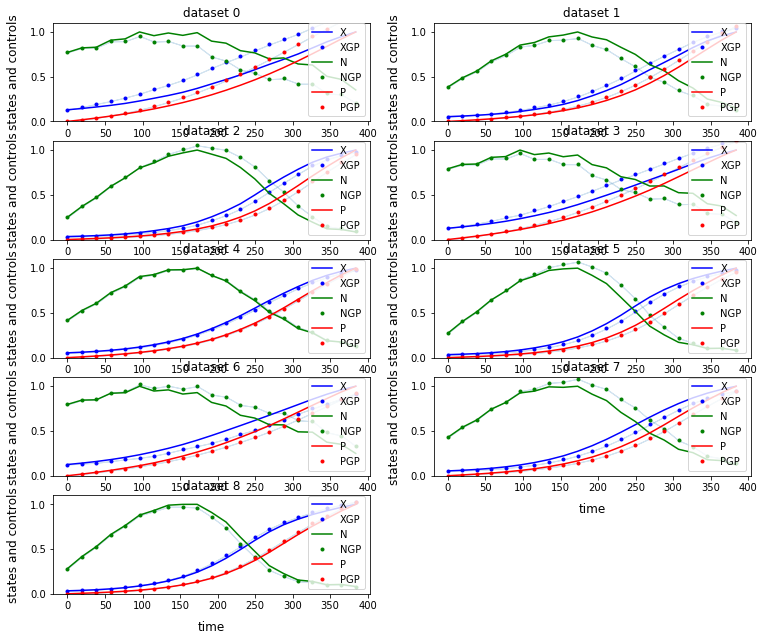

In [0]:
#############################
# --- Training datasets --- #
#############################

# --- problem parameters --- #
experiments = 9
steps_      = 20
tf          = 16.*24.
nd          = 3 
nu          = 2
x0          = np.array([0.1,150.0,0.0])
#Sigma_v     = np.array([0.8,250.0,80.0])*diag(np.ones(nd))*1e-4


# --- input arrays --- # (training)

LI_np  = np.array(L_I_0)
FCn_np = np.array(FCn_0)

# --- data collectors --- #
Xreal   = np.zeros((experiments*steps_, nd+nu ))
Yreal   = np.zeros((experiments*steps_, nd))
YmeanGP = np.zeros((experiments, steps_+1, nd))
YstdGP  = np.zeros((experiments, steps_+1, nd))
# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(12.5, 10.5)

# %%%%%%% computing GP %%%%%%% #

controls = np.array([L_I_0,FCn_0]) # shape (nu, nrun, steps)

for run_i in range(controls.shape[1]):

    GP_run                                = GP_simulate(GP_m, x0, 
                                                        controls[:,run_i,:])
    YmeanGP[run_i,:,:], YstdGP[run_i,:,:] = GP_run.multi_step_noprop()

# %%%%%%% computing real system and plot %%%%%%% #

for ri in range(0,experiments):
    u       = np.array([L_I_0[ri], FCn_0[ri]])
    
    # -- computing real system -- #
    m         = ModelIntegration(p, u, tf, x0)
    x_r, t_r  = m.simulation() 
    
    
    # -- gathering data states -- #
    t_                           = ri*steps_
    Xreal[t_:t_+steps_,:nd]      = x_r[:,:-1].T
    Yreal[t_:t_+steps_,:]        = x_r[:,1:].T
    # -- gathering data controls -- #
    Xreal[t_:t_+steps_, nd  :nd+1] = LI_np[ri,:].reshape(steps_,1)
    Xreal[t_:t_+steps_, nd+1:nd+2] = FCn_np[ri,:].reshape(steps_,1)
    
    # --- plot loop --- #   
    # setting up plot
    ax = fig.add_subplot(int(experiments/2.)+1, 2, ri+1)

    # labels and titles
    ax.set_title('dataset '+str(ri), fontsize=12)
    ax.set_xlabel('time', fontsize=12, labelpad=10)
    ax.set_ylabel('states and controls', fontsize=12, labelpad=10)

    # states
    col = ['b','g','r']
    for i in range(x_r.shape[0]):
        ax.plot(tt,x_r[i,:]/np.max(x_r[i,:]), color=col[i])
        ax.plot(tt,YmeanGP[ri,:,i]/np.max(x_r[i,:]),'.', color=col[i])
        
    # plot GP confidence intervals
        if i != 10:
            plt.gca().fill_between(tt, 
                               (YmeanGP[ri,:,i] - 2*YstdGP[ri,:,i])/np.max(x_r[i,:]), 
                               (YmeanGP[ri,:,i] + 2*YstdGP[ri,:,i])/np.max(x_r[i,:]), 
                               color='C0', alpha=0.2)    
        
    # controls
    #ax.step(tt[:-1],L_I_0[ri]/np.max(L_I_0[ri]))
    #ax.step(tt[:-1],FCn_0[ri]/np.max(FCn_0[ri]))

    ax.legend(('X','XGP', 'N', 'NGP', 'P', 'PGP'),
               loc='lower right')
    ax.set_ylim(0.0, 1.1)
plt.show()

### Plotting cross validation datasets

Here we add cross validation datasets and the GP state-space model is used to predict them

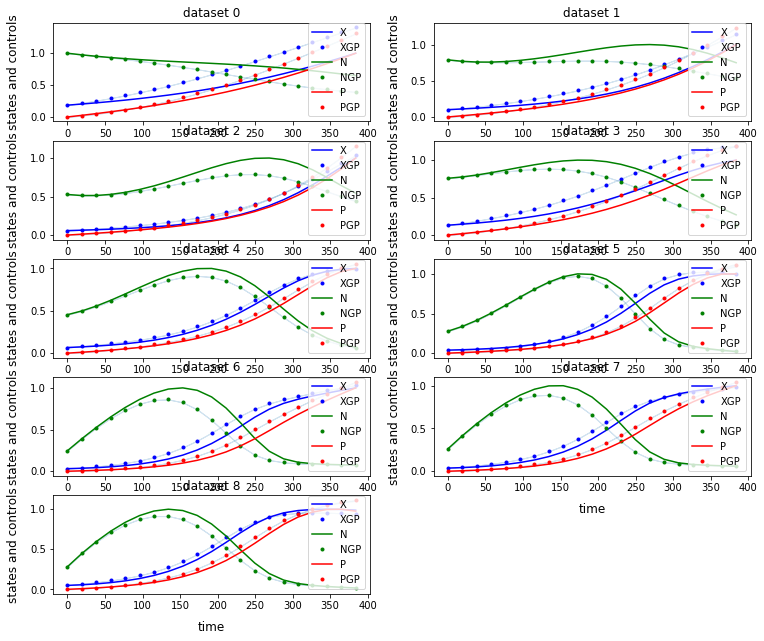

In [0]:
##############################################
# --- Creating Cross-Validation datasets --- #
##############################################

# L_I range [120, 300]
# FCn range [0.1, 5.0]

# --- problem parameters --- #
experiments = 9
steps_      = 20
tf          = 16.*24.
nd          = 3 
nu          = 2
x0          = np.array([0.1,150.0,0.0])
#Sigma_v     = np.array([0.8,250.0,80.0])*diag(np.ones(nd))*1e-4


# --- input arrays --- # (CV)
L_I_0  = [[120.+i*j for i in range(steps_)] for j in [3.,6.,9.]]
L_I_0 += [[120.+np.sin((i+3)/7.2)*j for i in range(steps_)] for j in [30.,90.,180.]]
L_I_0 += [[300.-j*i for i in range(steps_)] for j in [3.,6.,9.]]

FCn_0  = [[0.1+i*j for i in range(steps_)] for j in [0.05,0.13,0.245]]
FCn_0 += [[0.1+np.sin((i+3)/7.2)*j for i in range(steps_)] for j in [1.0,2.5,4.9]]
FCn_0 += [[5.-j*i for i in range(steps_)] for j in [0.05,0.13,0.245]]

LI_np  = np.array(L_I_0)
FCn_np = np.array(FCn_0)

# --- data collectors --- #
Xreal   = np.zeros((experiments*steps_, nd+nu ))
Yreal   = np.zeros((experiments*steps_, nd))
YmeanGP = np.zeros((experiments, steps_+1, nd))
YstdGP  = np.zeros((experiments, steps_+1, nd))
# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(12.5, 10.5)

# %%%%%%% computing GP %%%%%%% #

controls = np.array([L_I_0,FCn_0]) # shape (nu, nrun, steps)

for run_i in range(controls.shape[1]):

    GP_run                                = GP_simulate(GP_m, x0, 
                                                        controls[:,run_i,:])
    YmeanGP[run_i,:,:], YstdGP[run_i,:,:] = GP_run.multi_step_noprop()

# %%%%%%% computing real system and plot %%%%%%% #

for ri in range(0,experiments):
    u       = np.array([L_I_0[ri], FCn_0[ri]])
    
    # -- computing real system -- #
    m         = ModelIntegration(p, u, tf, x0)
    x_r, t_r  = m.simulation() 
    
    
    # -- gathering data states -- #
    t_                           = ri*steps_
    Xreal[t_:t_+steps_,:nd]      = x_r[:,:-1].T
    Yreal[t_:t_+steps_,:]        = x_r[:,1:].T
    # -- gathering data controls -- #
    Xreal[t_:t_+steps_, nd  :nd+1] = LI_np[ri,:].reshape(steps_,1)
    Xreal[t_:t_+steps_, nd+1:nd+2] = FCn_np[ri,:].reshape(steps_,1)
    
    # --- plot loop --- #   
    # setting up plot
    ax = fig.add_subplot(int(experiments/2.)+1, 2, ri+1)

    # labels and titles
    ax.set_title('dataset '+str(ri), fontsize=12)
    ax.set_xlabel('time', fontsize=12, labelpad=10)
    ax.set_ylabel('states and controls', fontsize=12, labelpad=10)

    # states
    col = ['b','g','r']
    for i in range(x_r.shape[0]):
        ax.plot(tt,x_r[i,:]/np.max(x_r[i,:]), color=col[i])
        ax.plot(tt,YmeanGP[ri,:,i]/np.max(x_r[i,:]),'.', color=col[i])
        
    # plot GP confidence intervals
        if i != 10:
            plt.gca().fill_between(tt, 
                               (YmeanGP[ri,:,i] - 3*YstdGP[ri,:,i])/np.max(x_r[i,:]), 
                               (YmeanGP[ri,:,i] + 3*YstdGP[ri,:,i])/np.max(x_r[i,:]), 
                               color='C0', alpha=0.2)    
        
    # controls
    #ax.step(tt[:-1],L_I_0[ri]/np.max(L_I_0[ri]))
    #ax.step(tt[:-1],FCn_0[ri]/np.max(FCn_0[ri]))

    ax.legend(('X','XGP', 'N', 'NGP', 'P', 'PGP'),
               loc='lower right')
    #ax.set_ylim(0.0, 1.1)
plt.show()

In [0]:
#############################
# --- Training datasets --- #
#############################

# --- problem parameters --- #
experiments = 9
steps_      = 20
tf          = 16.*24.
nd          = 3 
nu          = 2
x0          = np.array([0.1,150.0,0.0])
#Sigma_v     = np.array([0.8,250.0,80.0])*diag(np.ones(nd))*1e-4


# --- input arrays --- # (training)

LI_np  = np.array(L_I_0)
FCn_np = np.array(FCn_0)

# --- data collectors --- #
Xreal   = np.zeros((experiments*steps_, nd+nu ))
Yreal   = np.zeros((experiments*steps_, nd))
YmeanGP = np.zeros((experiments, steps_+1, nd))
YstdGP  = np.zeros((experiments, steps_+1, nd))
# --- plot options --- #
fig = plt.figure()
fig.set_size_inches(12.5, 10.5)

# %%%%%%% computing GP %%%%%%% #

controls = np.array([L_I_0,FCn_0]) # shape (nu, nrun, steps)

for run_i in range(controls.shape[1]):

    GP_run                                = GP_simulate(GP_m, x0, 
                                                        controls[:,run_i,:])
    YmeanGP[run_i,:,:], YstdGP[run_i,:,:] = GP_run.multi_step_withprop()

# %%%%%%% computing real system and plot %%%%%%% #

for ri in range(0,experiments):
    u       = np.array([L_I_0[ri], FCn_0[ri]])
    
    # -- computing real system -- #
    m         = ModelIntegration(p, u, tf, x0)
    x_r, t_r  = m.simulation() 
    
    
    # -- gathering data states -- #
    t_                           = ri*steps_
    Xreal[t_:t_+steps_,:nd]      = x_r[:,:-1].T
    Yreal[t_:t_+steps_,:]        = x_r[:,1:].T
    # -- gathering data controls -- #
    Xreal[t_:t_+steps_, nd  :nd+1] = LI_np[ri,:].reshape(steps_,1)
    Xreal[t_:t_+steps_, nd+1:nd+2] = FCn_np[ri,:].reshape(steps_,1)
    
    # --- plot loop --- #   
    # setting up plot
    ax = fig.add_subplot(int(experiments/2.)+1, 2, ri+1)

    # labels and titles
    ax.set_title('dataset '+str(ri), fontsize=12)
    ax.set_xlabel('time', fontsize=12, labelpad=10)
    ax.set_ylabel('states and controls', fontsize=12, labelpad=10)

    # states
    col = ['b','g','r']
    for i in range(x_r.shape[0]):
        ax.plot(tt,x_r[i,:]/np.max(x_r[i,:]), color=col[i])
        ax.plot(tt,YmeanGP[ri,:,i]/np.max(x_r[i,:]),'.', color=col[i])
        
    # plot GP confidence intervals
        if i != 10:
            plt.gca().fill_between(tt, 
                               (YmeanGP[ri,:,i] - 2*YstdGP[ri,:,i])/np.max(x_r[i,:]), 
                               (YmeanGP[ri,:,i] + 2*YstdGP[ri,:,i])/np.max(x_r[i,:]), 
                               color='C0', alpha=0.2)    
        
    # controls
    #ax.step(tt[:-1],L_I_0[ri]/np.max(L_I_0[ri]))
    #ax.step(tt[:-1],FCn_0[ri]/np.max(FCn_0[ri]))

    ax.legend(('X','XGP', 'N', 'NGP', 'P', 'PGP'),
               loc='lower right')
    ax.set_ylim(0.0, 1.1)
plt.show()

In [0]:
np.identity(3)*np.array([[1,5,3]]).squeeze()

array([[1., 0., 0.],
       [0., 5., 0.],
       [0., 0., 3.]])